<a href="https://colab.research.google.com/github/AbrarMahmud/Thesis_basic/blob/main/Audio_SP_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Syntax for installing libraries in Google-Colab
!pip install datasets[audio]

In [2]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-US", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})

#Note :Resampling

Some background on resampling: If an audio signal has been sampled at 8 kHz, so that it has 8000 sample readings per second, we know that the audio does not contain any frequencies over 4 kHz. This is guaranteed by the Nyquist sampling theorem. Because of this, we can be certain that in between the sampling points the original continuous signal always makes a smooth curve. Upsampling to a higher sampling rate is then a matter of calculating additional sample values that go in between the existing ones, by approximating this curve.
**Downsampling,**however, requires that we first filter out any frequencies that would be higher than the new Nyquist limit, before estimating the new sample points. ***In other words, you can't downsample by a factor 2x by simply throwing away every other sample — this will create distortions in the signal called aliases.*** Doing resampling correctly is tricky and best left to well-tested libraries such as librosa or 🤗 Datasets.

In [3]:
## For our case MINDS-14 dataset is at 8kHz sample rate
## So we need to upsample it

## To do so, use 🤗 Datasets’ cast_column method. This operation does not change the audio in-place
## but rather signals to datasets to resample the audio examples on the fly when they are loaded.

from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))




####Filtering the dataset
we might want to filter out any examples longer than 20s to prevent out-of-memory errors when training a model.

Below we use a **pre-defined**(by the library owner) way of filtering audion by duration from datsets library

In [4]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS
######################################################
# The list comprehension technique
# a = [1 ,2 ,3 ,4]
# b = [x**x for x in a] #here b = [1, 4, 27, 256]

######################################################
import librosa
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path = ii) for ii in minds["path"]]
minds = minds.add_column("duration",new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])

## Further more to remove irrelevant features using 🤗 Datasets’ remove_columns method:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 533
})

# Using a pre-trained model
(Model for automatic speech recognition (ASR))

**First,** the Whisper feature extractor pads/truncates a batch of audio examples such that all examples have an input length of 30s.

**The second operation** that the Whisper feature extractor performs is converting the padded audio arrays to log-mel spectrograms. As you recall, these spectrograms describe how the frequencies of a signal change over time, expressed on the mel scale and measured in decibels (the log part) to make the frequencies and amplitudes more representative of human hearing.

In [5]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

Pre-defined way of using **dataset library method** **and** transformers **feature extractor class**

First, let us observe the stucture each MINDS-14 dataset


In [6]:
print('**structure of MINDS-14(minds) dataset**\n')
print(minds)
print('\n\n**Eache element in mind dataset**\n')
minds[10]

**structure of MINDS-14(minds) dataset**

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 533
})


**Eache element in mind dataset**



{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~JOINT_ACCOUNT/602baf4fbb1e6d0fbce922b8.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~JOINT_ACCOUNT/602baf4fbb1e6d0fbce922b8.wav',
  'array': array([-3.71979550e-05, -3.78217082e-05,  3.99068813e-05, ...,
         -1.58256778e-04,  1.27971784e-04,  2.52639875e-04]),
  'sampling_rate': 16000},
 'transcription': 'how do I go about setting up a joint account for my wife and I',
 'intent_class': 11}

In [7]:
def prepare_dataset(example):
    audio = example["audio"]   ## Equivalent to minds["audio"]
    features = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"], padding=True)
    return features

# We can apply the data preparation function
# to all of our training examples using 🤗 Datasets’ map method:
minds = minds.map(prepare_dataset)
print('**structure of MINDS-14(minds) dataset**\n')
print(minds)

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

**structure of MINDS-14(minds) dataset**

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 533
})


As easy as that, we now have log-mel spectrograms as input_features in the dataset.

Let’s visualize it for one of the examples in the minds dataset:

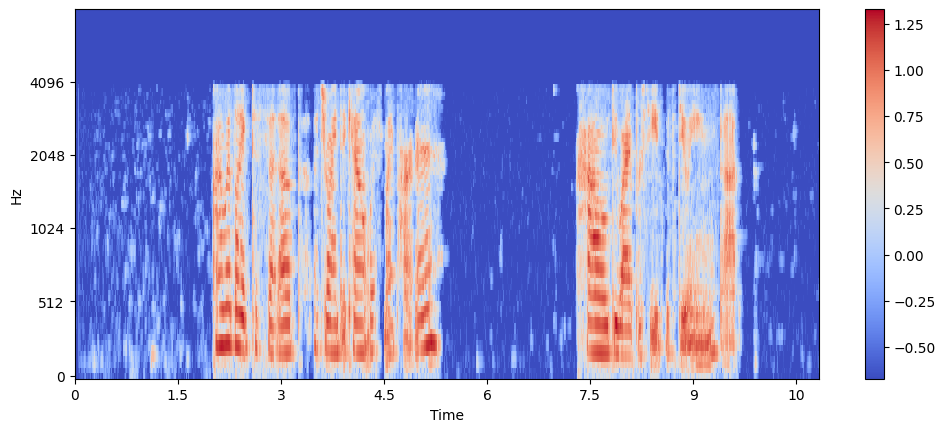

In [8]:
import numpy as np
import matplotlib.pyplot as plt
#import librosa.display
#example = minds[0]
input_features = minds[0]["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

We can load the **feature extractor** and **tokenizer** for Whisper and other multimodal models separately, or you can load **both via a so-called processor**. To make things even simpler, use AutoProcessor to load a model’s feature extractor and processor from a checkpoint, like this:

In [9]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

# |##############################################|



#Streaming audio data

 The xl (biggest) configuration of **GigaSpeech** dataset from SpeechColab contains 10,000 hours of training data and takes over 1TB of storage space for download and preparation.

Datasets library's **Streaming mode** allows us to load the data progressively as we iterate over the dataset.


#Note
I failed to run this portion
Because i am not signed in to gigaspeech dataset

In [12]:
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

FileNotFoundError: ignored

The only difference is that we can no longer access individual samples using Python indexing (i.e. gigaspeech["train"][sample_idx]). Instead, we have to iterate over the dataset.

In [ ]:
next(iter(gigaspeech["train"]))

## Or use the take() to get the first n elements
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)